# CMPS 320
## Lab 4:  Variable Selection and Regularization

In [1]:
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load the data
hitters_df = pd.read_csv('Hitters.csv')
hitters_df.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


#### Data Preparation

First of all, we note that the Salary variable is missing for some of the players. The isnull() function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a TRUE value for any elements that are missing, and a FALSE value for non-missing elements. The sum() function can then be used to count all of the missing elements:

In [3]:
print("Number of null values:", hitters_df["Salary"].isnull().sum())

Number of null values: 59


We see that Salary is missing for 59 players. The dropna() function removes all of the rows that have missing values in any variable:

In [4]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_df.shape)

# Drop any rows the contain missing values, along with the player names
hitters_df_clean = hitters_df.dropna().drop('Player', axis=1)

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", hitters_df_clean.shape)

# One last check: should return 0
print("Number of null values:", hitters_df_clean["Salary"].isnull().sum())

Dimensions of original data: (322, 21)
Dimensions of modified data: (263, 20)
Number of null values: 0


Some of our predictors are categorical, so we'll want to clean those up as well. We'll ask pandas to generate dummy variables for them, separate out the response variable, and stick everything back together again:

In [5]:
dummies = pd.get_dummies(hitters_df_clean[['League', 'Division', 'NewLeague']])

y = hitters_df_clean.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = hitters_df_clean.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

In [6]:
X

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497.0,127.0,7.0,65.0,48.0,37.0,5.0,2703.0,806.0,32.0,379.0,311.0,138.0,325.0,9.0,3.0,1,0,1
318,492.0,136.0,5.0,76.0,50.0,94.0,12.0,5511.0,1511.0,39.0,897.0,451.0,875.0,313.0,381.0,20.0,0,0,0
319,475.0,126.0,3.0,61.0,43.0,52.0,6.0,1700.0,433.0,7.0,217.0,93.0,146.0,37.0,113.0,7.0,0,1,0
320,573.0,144.0,9.0,85.0,60.0,78.0,8.0,3198.0,857.0,97.0,470.0,420.0,332.0,1314.0,131.0,12.0,0,0,0


### Best Subset Selection

In [7]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [8]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

This returns a DataFrame containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors  k :

In [9]:
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 19 models on 1 predictors in 0.04415011405944824 seconds.
Processed 171 models on 2 predictors in 0.2680950164794922 seconds.
Processed 969 models on 3 predictors in 1.4884228706359863 seconds.
Processed 3876 models on 4 predictors in 5.879946231842041 seconds.
Processed 11628 models on 5 predictors in 18.140693187713623 seconds.
Processed 27132 models on 6 predictors in 42.45112323760986 seconds.
Processed 50388 models on 7 predictors in 74.29740905761719 seconds.
Total elapsed time: 143.285306930542 seconds.


Now we have one big DataFrame that contains the best models we've generated along with their RSS:

In [10]:
print(models_best)

               RSS                                              model
1  43213925.909868  <statsmodels.regression.linear_model.Regressio...
2  30733054.433644  <statsmodels.regression.linear_model.Regressio...
3  29410713.176731  <statsmodels.regression.linear_model.Regressio...
4  27976782.522603  <statsmodels.regression.linear_model.Regressio...
5  27187795.009508  <statsmodels.regression.linear_model.Regressio...
6  26397720.512772  <statsmodels.regression.linear_model.Regressio...
7  26064130.610341  <statsmodels.regression.linear_model.Regressio...


If we want to access the details of each model, we can get a full rundown of a single model using the summary() function:

In [11]:
print(models_best.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              416.7
Date:                Tue, 21 Feb 2023   Prob (F-statistic):                    5.80e-82
Time:                        09:08:31   Log-Likelihood:                         -1907.6
No. Observations:                 263   AIC:                                      3819.
Df Residuals:                     261   BIC:                                      3826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

This output indicates that the best two-variable model contains only Hits and CRBI. To save time, we only generated results up to the best 7-variable model. You can use the functions we defined above to explore as many variables as are desired.

In [12]:
# Show the best 19-variable model 
print(getBest(19)["model"].summary())

Processed 1 models on 19 predictors in 0.004975080490112305 seconds.
                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.810
Model:                            OLS   Adj. R-squared (uncentered):              0.795
Method:                 Least Squares   F-statistic:                              54.64
Date:                Tue, 21 Feb 2023   Prob (F-statistic):                    1.31e-76
Time:                        09:08:31   Log-Likelihood:                         -1877.9
No. Observations:                 263   AIC:                                      3794.
Df Residuals:                     244   BIC:                                      3862.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P

Rather than letting the results of our call to the summary() function print to the screen, we can access just the parts we need using the model's attributes. For example, if we want the  $R^2$  value:

In [13]:
models_best.loc[2, "model"].rsquared

0.7614950002332872

In [14]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
5    0.789008
6    0.795140
7    0.797728
dtype: float64

### Forward Stepwise Selection

In [15]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [16]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 1 predictors in 0.03569197654724121 seconds.
Processed  18 models on 2 predictors in 0.028595924377441406 seconds.
Processed  17 models on 3 predictors in 0.024428844451904297 seconds.
Processed  16 models on 4 predictors in 0.032054901123046875 seconds.
Processed  15 models on 5 predictors in 0.029116153717041016 seconds.
Processed  14 models on 6 predictors in 0.027134180068969727 seconds.
Processed  13 models on 7 predictors in 0.023188114166259766 seconds.
Processed  12 models on 8 predictors in 0.024690866470336914 seconds.
Processed  11 models on 9 predictors in 0.024942874908447266 seconds.
Processed  10 models on 10 predictors in 0.020064115524291992 seconds.
Processed  9 models on 11 predictors in 0.017352819442749023 seconds.
Processed  8 models on 12 predictors in 0.016024112701416016 seconds.
Processed  7 models on 13 predictors in 0.015052080154418945 seconds.
Processed  6 models on 14 predictors in 0.015130043029785156 seconds.
Processed  5 models 

In [17]:
print(models_fwd.loc[1, "model"].summary())
print(models_fwd.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.665
Model:                            OLS   Adj. R-squared (uncentered):              0.663
Method:                 Least Squares   F-statistic:                              519.2
Date:                Tue, 21 Feb 2023   Prob (F-statistic):                    4.20e-64
Time:                        09:08:32   Log-Likelihood:                         -1952.4
No. Observations:                 263   AIC:                                      3907.
Df Residuals:                     262   BIC:                                      3910.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We see that using forward stepwise selection, the best one-variable model contains only Hits, and the best two-variable model additionally includes CRBI. Let's see how the models stack up against best subset selection:

In [18]:
print(models_best.loc[6, "model"].summary())
print(models_fwd.loc[6, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.795
Model:                            OLS   Adj. R-squared (uncentered):              0.790
Method:                 Least Squares   F-statistic:                              166.3
Date:                Tue, 21 Feb 2023   Prob (F-statistic):                    1.79e-85
Time:                        09:08:32   Log-Likelihood:                         -1887.6
No. Observations:                 263   AIC:                                      3787.
Df Residuals:                     257   BIC:                                      3809.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Backward Stepwise Selection

In [19]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [20]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 18 predictors in 0.04311394691467285 seconds.
Processed  18 models on 17 predictors in 0.03540921211242676 seconds.
Processed  17 models on 16 predictors in 0.03672909736633301 seconds.
Processed  16 models on 15 predictors in 0.03481793403625488 seconds.
Processed  15 models on 14 predictors in 0.03123617172241211 seconds.
Processed  14 models on 13 predictors in 0.028888225555419922 seconds.
Processed  13 models on 12 predictors in 0.02396225929260254 seconds.
Processed  12 models on 11 predictors in 0.02598404884338379 seconds.
Processed  11 models on 10 predictors in 0.02112412452697754 seconds.
Processed  10 models on 9 predictors in 0.01805400848388672 seconds.
Processed  9 models on 8 predictors in 0.018658876419067383 seconds.
Processed  8 models on 7 predictors in 0.015215873718261719 seconds.
Processed  7 models on 6 predictors in 0.014458179473876953 seconds.
Processed  6 models on 5 predictors in 0.014199972152709961 seconds.
Processed  5 models on 4

For this data, the best one-variable through six-variable models are each identical for best subset and forward selection. However, the best seven-variable models identified by forward stepwise selection, backward stepwise selection, and best subset selection are different:

In [21]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[7, "model"].params)

------------
Best Subset:
------------
Hits            1.680029
Walks           3.399961
CAtBat         -0.328835
CHits           1.347017
CHmRun          1.349373
PutOuts         0.248166
Division_W   -111.943760
dtype: float64


In [22]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[7, "model"].params)

-----------------
Foward Selection:
-----------------
Hits            7.277149
CRBI            0.652415
Division_W   -110.656338
PutOuts         0.259787
AtBat          -1.644651
Walks           3.684324
League_N       49.978410
dtype: float64


In [23]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[7, "model"].params)

-------------------
Backward Selection:
-------------------
AtBat         -1.601655
Hits           6.148449
Walks          5.866033
CRuns          1.097453
CWalks        -0.650614
PutOuts        0.310125
Division_W   -95.027171
dtype: float64


### Ridge Regression

In [24]:
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

We will use the sklearn package in order to perform ridge regression and the lasso. The main functions in this package that we care about are Ridge(), which can be used to fit ridge regression models, and Lasso() which will fit lasso models. They also have cross-validated counterparts: RidgeCV() and LassoCV()

The Ridge() function has an alpha argument ( λ , but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit:

In [25]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

Associated with each alpha value is a vector of ridge regression coefficients, which we'll store in a matrix coefs. In this case, it is a  19×100  matrix, with 19 rows (one for each predictor) and 100 columns (one for each value of alpha). Remember that we'll want to standardize the variables so that they are on the same scale. To do this, we can use the normalize = True parameter:

In [26]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the 

(100, 19)

We expect the coefficient estimates to be much smaller, in terms of  $l_2$  norm, when a large value of alpha is used, as compared to when a small value of alpha is used. Let's plot and find out:

Text(0, 0.5, 'weights')

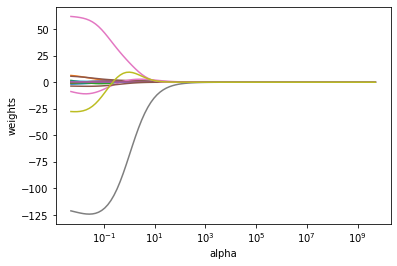

In [27]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order to estimate the test error of ridge regression and the lasso:

In [28]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

Next we fit a ridge regression model on the training set, and evaluate its MSE on the test set, using  λ=4 :

In [29]:
ridge2 = Ridge(alpha = 4, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

AtBat           0.098658
Hits            0.446094
HmRun           1.412107
Runs            0.660773
RBI             0.843403
Walks           1.008473
Years           2.779882
CAtBat          0.008244
CHits           0.034149
CHmRun          0.268634
CRuns           0.070407
CRBI            0.070060
CWalks          0.082795
PutOuts         0.104747
Assists        -0.003739
Errors          0.268363
League_N        4.241051
Division_W    -30.768885
NewLeague_N     4.123474
dtype: float64
106216.52238005561


/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


The test MSE when alpha = 4 is 106216. Now let's see what happens if we use a huge value of alpha, say  $10^{10}$ :

In [30]:
ridge3 = Ridge(alpha = 10**10, normalize = True)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3))          # Calculate the test MSE

AtBat          1.317464e-10
Hits           4.647486e-10
HmRun          2.079865e-09
Runs           7.726175e-10
RBI            9.390640e-10
Walks          9.769219e-10
Years          3.961442e-09
CAtBat         1.060533e-11
CHits          3.993605e-11
CHmRun         2.959428e-10
CRuns          8.245247e-11
CRBI           7.795451e-11
CWalks         9.894387e-11
PutOuts        7.268991e-11
Assists       -2.615885e-12
Errors         2.084514e-10
League_N      -2.501281e-09
Division_W    -1.549951e-08
NewLeague_N   -2.023196e-09
dtype: float64
172862.23580379886


/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.

Okay, so fitting a ridge regression model with alpha = 4 leads to a much lower test MSE than fitting a model with just an intercept. We now check whether there is any benefit to performing ridge regression with alpha = 4 instead of just performing least squares regression. Recall that least squares is simply ridge regression with alpha = 0.

In [31]:
ridge2 = Ridge(alpha = 0, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))           # Calculate the test MSE

AtBat           -1.821115
Hits             4.259156
HmRun           -4.773401
Runs            -0.038760
RBI              3.984578
Walks            3.470126
Years            9.498236
CAtBat          -0.605129
CHits            2.174979
CHmRun           2.979306
CRuns            0.266356
CRBI            -0.598456
CWalks           0.171383
PutOuts          0.421063
Assists          0.464379
Errors          -6.024576
League_N       133.743163
Division_W    -113.743875
NewLeague_N    -81.927763
dtype: float64
116690.46856660741


/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


It looks like we are indeed improving over regular least-squares!

Instead of arbitrarily choosing alpha  =4 , it would be better to use cross-validation to choose the tuning parameter alpha. We can do this using the cross-validated ridge regression function, RidgeCV(). By default, the function performs generalized cross-validation.



In [32]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


0.5748784976988678

Therefore, we see that the value of alpha that results in the smallest cross-validation error is 0.57. What is the test MSE associated with this value of alpha?

In [33]:
ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))

/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


99825.6489629273

This represents a further improvement over the test MSE that we got using alpha  =4 . Finally, we refit our ridge regression model on the full data set, using the value of alpha chosen by cross-validation, and examine the coefficient estimates.

In [34]:
ridge4.fit(X, y)
pd.Series(ridge4.coef_, index = X.columns)

/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


AtBat           0.055838
Hits            0.934879
HmRun           0.369048
Runs            1.092480
RBI             0.878259
Walks           1.717770
Years           0.783515
CAtBat          0.011318
CHits           0.061101
CHmRun          0.428333
CRuns           0.121418
CRBI            0.129351
CWalks          0.041990
PutOuts         0.179957
Assists         0.035737
Errors         -1.597699
League_N       24.774519
Division_W    -85.948661
NewLeague_N     8.336918
dtype: float64

As expected, none of the coefficients are exactly zero - ridge regression does not perform variable selection!

### LASSO

We saw that ridge regression with a wise choice of alpha can outperform least squares as well as the null model on the Hitters data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression. 

In order to fit a lasso model, we'll use the Lasso() function; however, this time we'll need to include the argument max_iter = 10000. Other than that change, we proceed just as we did in fitting a ridge model:

/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To repro

/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To repro

/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To repro

/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To repro

Text(0, 0.5, 'weights')

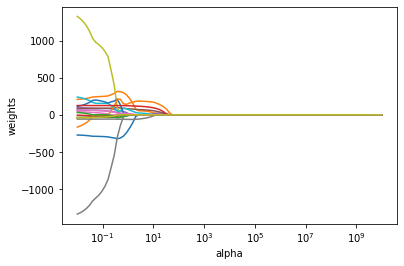

In [35]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Notice that in the coefficient plot that depending on the choice of tuning parameter, some of the coefficients are exactly equal to zero. We now perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [36]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/otwenebo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To repro

104960.65853895503

This is substantially lower than the test set MSE of the null model and of least squares, and only a little worse than the test MSE of ridge regression with alpha chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in that the resulting coefficient estimates are sparse. Here we see that 13 of the 19 coefficient estimates are exactly zero:

In [37]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat           0.000000
Hits            1.082446
HmRun           0.000000
Runs            0.000000
RBI             0.000000
Walks           2.906388
Years           0.000000
CAtBat          0.000000
CHits           0.000000
CHmRun          0.219367
CRuns           0.000000
CRBI            0.513975
CWalks          0.000000
PutOuts         0.368401
Assists        -0.000000
Errors         -0.000000
League_N        0.000000
Division_W    -89.064338
NewLeague_N     0.000000
dtype: float64